# Working with Prompt Template Assets for a Retrieval-Augmented Generation task in watsonx.governance

This notebook will create a retrieval-augmented generation (RAG) prompt template asset (PTA) in a given project, configure watsonx.governance to monitor that PTA and evaluate generative quality metrics and model health metrics, and then promote the prompt template asset to a space and do the same evaluation.

If you wish to execute this notebook for task types other than RAG, refer to [Evaluating prompt template asset of different task types](https://github.com/IBM/watson-openscale-samples/blob/main/IBM%20Cloud/WML/notebooks/watsonx/README.md) for guidance on evaluating prompt templates for other available task types.

This notebook should be run using a Python 3.10 or greater runtime environment. If you are viewing this notebook in Watson Studio and do not see Python 3.10.x or higher in the upper right corner of your screen, please update the runtime now.

## Learning goals

- Create a prompt template asset Cloud project
- Configure watsonx.governance to monitor the created prompt template asset 
- Evaluate generative quality metrics and model health metrics
- Promote the prompt template asset to a space
- Evaluate the prompt template asset in a space 

## Prerequisites

- Service credentials for IBM watsonx.governance are required
- Watson OpenScale (WOS) credentials are required
- Watsonx AI credentials are required
- A `.csv` file containing test data to be evaluated
- ID of the project in which you want to create the PTA
- ID of the space to which you want to promote the PTA

## Contents

[Evaluating a Prompt Template Asset from a project](#evaluateproject)
- [Step 1 - Setup](#settingup)
- [Step 2 - Create a Prompt template](#prompt)
- [Step 3 - Setup the prompt template](#ptatsetup)
- [Step 4 - Risk evaluations for the PTA subscription](#evaluate)
- [Step 5 - Display the Model Risk metrics](#mrmmetric)
- [Step 6 - Display the Generative AI Quality metrics](#genaimetrics)
- [Step 7 - Plot faithfulness and answer relevance metrics against records](#plotproject)
- [Step 8 - See factsheets information](#factsheetsspace)

[Evaluating a Prompt Template Asset from a space](#evaluatespace)
- [Step 9 - Promote a PTA to a space](#promottospace)
- [Step 10 - Create a deployment for a PTA in a space](#ptadeployment)
- [Step 11 - Set up the PTA in a space for evaluation with supported monitor parameters](#ptaspace)
- [Step 12 - Score the model and configure monitors](#score)
- [Step 13 - Display the source attributions for a record](#attributions)
- [Step 14 - Plot faithfulness and answer relevance metrics against records](#plotspace)
- [Step 15 - See factsheets information from a space](#factsheetsproject)

## Evaluating a Prompt Template Asset from a project <a name="evaluateproject"></a>

In the first section of this notebook, you will learn how to:

1. Create a PTA in a project
2. Create a `development`-type subscription for a PTA in OpenScale
3. Configure monitors supported by OpenScale for the subscription
4. Perform risk evaluations against the PTA subscription with a sample set of test data
5. Display the metrics generated with the risk evaluation
6. Display the factsheets information for the subscription

## Step 1 - Setup <a name="settingup"></a>

### Install the necessary packages

In [ ]:
!pip install -U ibm-watson-openscale | tail -n 1
!pip install --upgrade ibm-watsonx-ai | tail -n 1
!pip install matplotlib

**Note**: you may need to restart the kernel to use updated packages.

### Configure your credentials

In [ ]:
IAM_URL = "https://iam.cloud.ibm.com"
DATAPLATFORM_URL = "https://api.dataplatform.cloud.ibm.com"
FACTSHEET_URL = "https://dataplatform.cloud.ibm.com"
SERVICE_URL = "https://aiopenscale.cloud.ibm.com"
CLOUD_API_KEY = ""  # YOUR_CLOUD_API_KEY

CREDENTIALS = {
    "url": "https://us-south.ml.cloud.ibm.com",
    "apikey": CLOUD_API_KEY,
}

### Configure your project ID

To set up a development-type subscription in Watson OpenScale, the PTA must be within a cloud project. Supply the project ID where the PTA needs to be created.

In [ ]:
project_id = "<YOUR_PROJECT_ID>"

### Configure your space ID

You can use an existing space, or you can create a new space to promote the model.

#### (Optional) If you choose an existing space

Set variable for an existing space:

In [ ]:
use_existing_space = True  # Set as False to create a new space

Import watsonx_ai client:

In [3]:
import json
from ibm_watsonx_ai import APIClient

wx_ai_client = APIClient(CREDENTIALS)
wx_ai_client.version

'1.1.22'

List the available spaces:

In [4]:
wx_ai_client.spaces.list()

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50


,ID,NAME,CREATED
0,a063001f-14c6-4dc9-b373-3a700a43bb00,Sample space,2024-11-07T16:15:45.936Z
1,90f7c315-62a5-4f1f-a86f-cb29539daef7,test_full_flow,2024-10-11T11:53:33.716Z
2,74557a01-62df-49f8-9be1-571f7d26ee28,function deployment spcae,2024-06-26T17:16:46.548Z


Add the existing space name to the following cell:

In [ ]:
existing_space_id = "<YOUR_SPACE_ID>"

#### (Optional) If you choose to create a new space

Set variable for a new space:

In [5]:
use_existing_space = False  # Set as True to use an existing space

Tip: `INSTANCE_NAME`, `CRN` and `COS_RESOURCE_CRN` are required only if you are pointing to your cloud openscale instance, Your `INSTANCE_NAME` and `CRN` can be read from the [Cloud console](https://cloud.ibm.com/resources). From that page, goto `Resours list`, copy the name of your Watsonx AI instance listed there. Select the row corresponding to your instance, and copy the CRN displayed in the popup on the right side of the page

In [ ]:
#####################################################################################
# Paste your Watsonx AI INSTANCE_NAME, CRN in the following field and then run this cell.
######################################################################################
INSTANCE_NAME = "<YOUR_INSTANCE_NAME>"
CRN = "<YOUR_CRN>"

In [ ]:
COS_RESOURCE_CRN = "<YOUR_COS_RESOURCE_CRN>"

Create a name for your new space:

In [ ]:
space_name = "<NEW_SPACE_NAME>"

Set up your new space:

In [9]:
if use_existing_space == True:
    space_id = existing_space_id
else:
    space_meta_data = {
        wx_ai_client.spaces.ConfigurationMetaNames.NAME: space_name,
        wx_ai_client.spaces.ConfigurationMetaNames.STORAGE: {
            "resource_crn": COS_RESOURCE_CRN
        },
        wx_ai_client.spaces.ConfigurationMetaNames.COMPUTE: {
            "name": INSTANCE_NAME,
            "crn": CRN,
        },
        wx_ai_client.spaces.ConfigurationMetaNames.TYPE: "wx",
    }

    space_id = wx_ai_client.spaces.store(meta_props=space_meta_data)["metadata"]["id"]
wx_ai_client.set.default_space(space_id)
print(space_id)

Space has been created. However some background setup activities might still be on-going. Check for 'status' field in the response. It has to show 'active' before space can be used. If it's not 'active', you can monitor the state with a call to spaces.get_details(space_id). Alternatively, use background_mode=False when calling client.spaces.store().
7d195a51-8938-4fc7-a2b6-cf8e254d67c5


### Create an access token

The following function generates an IAM access token using the provided credentials. The API calls for creating and scoring prompt template assets utilize the token generated by this function.

In [10]:
import requests, json


def generate_access_token():
    headers = {}
    headers["Content-Type"] = "application/x-www-form-urlencoded"
    headers["Accept"] = "application/json"
    data = {
        "grant_type": "urn:ibm:params:oauth:grant-type:apikey",
        "apikey": CLOUD_API_KEY,
        "response_type": "cloud_iam",
    }
    response = requests.post(IAM_URL + "/identity/token", data=data, headers=headers)
    json_data = response.json()
    iam_access_token = json_data["access_token"]
    return iam_access_token


iam_access_token = generate_access_token()

## Step 2 - Create a Prompt template <a name="prompt"></a>

Create a prompt template for a RAG task:

In [11]:
credentials = {"apikey": CLOUD_API_KEY, "url": CREDENTIALS["url"]}

In [12]:
from ibm_watsonx_ai.foundation_models.prompts import (
    PromptTemplate,
    PromptTemplateManager,
)
from ibm_watsonx_ai.foundation_models.utils.enums import ModelTypes

prompt_mgr = PromptTemplateManager(credentials=credentials, project_id=project_id)

prompt_template = PromptTemplate(
    name="RAG QA",
    model_id=ModelTypes.FLAN_T5_XL,
    task_ids=["retrieval_augmented_generation"],
    input_prefix="",
    output_prefix="",
    input_text="Answer the below question from the given context only and do not use the knowledge outside the context.\n\nContext: {context1} {context2} {context3}\nQuestion: {question}\nAnswer:",
    input_variables=["context1", "context2", "context3", "question"],
)


stored_prompt_template = prompt_mgr.store_prompt(prompt_template)
project_pta_id = stored_prompt_template.prompt_id
project_pta_id

'67abfe24-5f2c-4a30-bd54-22867e199eb0'

## Step 3 - Set up the Prompt template <a name="ptatsetup"></a>

### Configure OpenScale

In [13]:
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

from ibm_watson_openscale import *
from ibm_watson_openscale.supporting_classes.enums import *
from ibm_watson_openscale.supporting_classes import *


service_instance_id = None  # Update this to refer to a particular service instance
authenticator = IAMAuthenticator(apikey=CLOUD_API_KEY, url=IAM_URL)
wos_client = APIClient(
    authenticator=authenticator,
    service_url=SERVICE_URL,
    service_instance_id=service_instance_id,
)
print(wos_client.version)

3.0.41


### List available OpenScale datamarts and configure the datamart ID

In [14]:
wos_client.data_marts.show()

None,None,True,active,2024-07-11 10:10:47.627000+00:00,dea2ecd3-2a6c-4fdd-8736-136b706d3707


In [ ]:
data_mart_id = "<YOUR_DATA_MART_ID>"

### Set up the PTA in the project for evaluation with supported monitor parameters

The PTAs from a project are only supported with a `development`-type operational space ID. Running the following cell will create a `development`-type subscription from the PTA created within your project.

The available parameters that can be passed for the `execute_prompt_setup` function are:

 * `prompt_template_asset_id`: ID of the PTA for which a subscription needs to be created
 * `label_column`: The name of the column containing the ground truth or actual labels
 * `project_id`: The ID of the project
 * `space_id`: The ID of the space
 * `deployment_id`: (optional) The ID of the deployment
 * `operational_space_id`: The rank of the environment in which the monitoring is happening. Accepted values are `development`, `pre_production`, `production`
 * `problem_type`: (optional) The task type to monitor for the given PTA
 * `classification_type`: The classification type (`binary`/`multiclass`) applicable only for the `classification` problem (task) type
 * `input_data_type`: The input data type
 * `supporting_monitors`: Monitor configuration for the subscription to be created
 * `background_mode`: When `True`, the prompt setup operation will be executed in the background

### For computing answer quality and retrieval quality metrics you are required to configure LLM As Judge.

To compute metrics using LLM As Judge a generative_ai_evaluator integrated system should to be created and provided during prompt setup.

#### Create a Generative AI evaluator
The Generative AI Evaluator can be any model from watsonx.ai or a custom endpoint invoking external models

Supported evaluator types
* watsonx.ai (for connecting to watsonx.ai in local Cloud)
* custom (for connecting to any external models)

#### Integrated System parameters
| Parameter | Description |
|:-|:-|
| `name` | Name for the evaluator. |
| `description` | Description for the evaluator. |
| `type` | The type of integrated system. Provide `generative_ai_evaluator`. |
| `parameters` | The evaluator configuration details like `evaluator_type` and `model_id`. |
| `credentials` | The user credentials |
| `connection` [Optional]| The scoring endpoint details when the evaluator is of type `custom`. |

As an example, an evaluator using FLAN_UL2 model from watsonx.ai instance present in the same Cloud is created below. The other models which can be used from watsonx.ai are FLAN_T5_XXL, FLAN_UL2, FLAN_T5_XL, MIXTRAL_8X7B_INSTRUCT_V01.
For more details on the parameters and to create the other supported evaluators please refer to the link [Generative AI evaluator templates](https://github.com/IBM/watson-openscale-samples/wiki/Generative-AI-Evaluator-templates#for-ibm-watsonxgovernance-in-cloud).

If you prefer to go with custom evaluator, please refer [Custom Evaluator Creation](https://github.com/IBM/watson-openscale-samples/tree/main/WatsonX.Governance/Cloud/GenAI/samples/custom_evaluators) guide. This provides step-by-step instructions on how to wrap your model inside a python function and deploy it for using as a custom generative AI evaluator.

You can also utilize fine-tuned small models within the runtime-24.1 environment in watsonx.ai for evaluating metrics such as faithfulness, answer relevance and retrieval quality. This can be done by creating a metric specific custom evaluator and passing them during prompt setup. The process for creating a custom evaluator specific to this use-case is described here, [NLP Custom Evaluator Creation](https://github.com/IBM/watson-openscale-samples/tree/main/WatsonX.Governance/Cloud/GenAI/samples/custom_evaluators/Watson_NLP_custom_evaluator.ipynb). Answer Similarity metric cannot be computed using fine tuned small models. You are required to use Generative AI Evaluator with LLM as Judge.


In [16]:
from ibm_watsonx_ai.foundation_models.utils.enums import ModelTypes

gen_ai_evaluator = wos_client.integrated_systems.add(
    name="<YOUR METRIC EVALUATOR NAME>",
    description="<YOUR METRIC EVALUATOR DESC>",
    type="generative_ai_evaluator",
    parameters={"evaluator_type": "watsonx.ai", "model_id": ModelTypes.FLAN_UL2.value},
    credentials={
        "wml_location": "cloud",
        "apikey": CLOUD_API_KEY,
    },
)

# get evaluator integrated system ID
result = gen_ai_evaluator.result._to_dict()
evaluator_id = result["metadata"]["id"]
evaluator_id

'afdfe677-aeb1-4ba0-9f7c-a12df7e56435'

#### Generative AI monitor parameters

##### Generative AI evaluator parameters
The generative_ai_evaluator details can be provided at the global level under `generative_ai_quality.parameters` to use the same evaluator for all the Answer quality metrics(Faithfulness, Answer relevance, Answer similarity) and Retrieval quality metrics(Context relevance, Retrieval precision, Average precision, Reciprocal rank, Hit rate, Normalized Discounted Cumulative Gain).

The generative ai evaluator can be specified at metric level to use different evaluators for each of the metric. The metrics under which generative_ai_evaluator parameter can be specified are faithfulness, answer_relevance, answer_similarity and retrieval_quality. The generative_ai_evaluator at the metric level takes precedence over the generative_ai_evaluator at global level

| Parameter | Description | Default Value |
|:-|:-|:-|
| `enabled`| The flag to enable generative ai evaluator |  |
| `evaluator_id`| The id of the generative ai evaluator integrated system. |  |

##### Faithfulness, Context relevance, Answer relevance and Answer similarity parameters
Applicable when using the Generative AI evaluator created for LLMs and not for the fine-tuned small models within the runtime-24.1 environment in watsonx.ai

| Parameter | Description |
|:-|:-|
| `metric_prompt_template` [Optional]| The prompt template used to compute each metric values. User can override the prompt template used by watsonx.governance to compute the metric using this parameter. The prompt template should use the variables {context}, {question}, {answer}, {reference_answer} as needed and these variable values will be filled with the actual data while calling the scoring function. The prompt response should return the metric value in the range 1-10 for the respective metric and in one of the formats ["4", "7 star", "star: 8", "stars: 9"] as answer. |

Applicable when using the fine-tuned small models within the runtime-24.1 environment in watsonx.ai.   
Not applicable for Answer similarity as the metric cannot be computed using fine-tuned small models.

| Parameter | Description | Default Value | Possible Value(s) |
|:-|:-|:-|:-|
| sample_size [Optional]| The metrics are computed for a maximum of 50 LLM responses.  If you wish to compute it for a smaller number of responses, set the sample_size value to a lower number. If the number of records in the input data frame are more than the sample size, a uniform random sample will taken for computation. | `50` | Integer between 0 to 50. Max value supported is 50 |

##### Unsuccessful requests parameters

| Parameter | Description | Default Value |
|:-|:-|:-|
| `unsuccessful_phrases` [Optional]| The list of phrases to be used for comparing the model output to determine whether the request is unsuccessful or not. | `["i don't know", "i do not know", "i'm not sure", "i am not sure", "i'm unsure", "i am unsure", "i'm uncertain", "i am uncertain", "i'm not certain", "i am not certain", "i can't fulfill", "i cannot fulfill"]` |


In [17]:
# Update the label_column, context_fields, question_field values based on the prompt and test data used
label_column = "answer"
context_fields = ["context1", "context2", "context3"]
question_field = "question"

operational_space_id = "development"
problem_type = "retrieval_augmented_generation"
input_data_type = "unstructured_text"


monitors = {
    "generative_ai_quality": {
        "parameters": {
            "generative_ai_evaluator": { # global LLM as judge configuration
               "enabled": True,
               "evaluator_id": evaluator_id,
            },
            "min_sample_size": 5,
            "metrics_configuration": {
                "faithfulness": {
                    # "sample_size": 2, # Not supported for LLM as Judge
                    # "metric_prompt_template": "", # adding custom template
                    # Uncomment generative_ai_evaluator to use a different evaluator for this metric.
                    # Takes higher precedence than the generative_ai_evaluator specified at global level.
                    # "generative_ai_evaluator": {  # metric specific LLM as judge configuration
                    #     "enabled": True,
                    #     "evaluator_id": evaluator_id,
                    # },
                },
                "answer_relevance": {
                    # "sample_size": 2, # Not supported for LLM as Judge
                    # "metric_prompt_template": "", # adding custom template
                    # Uncomment generative_ai_evaluator to use a different evaluator for this metric
                    # Takes higher precedence than the generative_ai_evaluator specified at global level.
                    # "generative_ai_evaluator": {  # metric specific LLM as judge configuration
                    #     "enabled": True,
                    #     "evaluator_id": evaluator_id,
                    # },
                },
                "rouge_score": {},
                "exact_match": {},
                "bleu": {},
                "unsuccessful_requests": {
                    # "unsuccessful_phrases": []
                },
                "hap_input_score": {},
                "hap_score": {},
                "pii": {},
                "pii_input": {},
                "retrieval_quality": {
                    # "sample_size": 2, # Not supported for LLM as Judge
                    # Uncomment generative_ai_evaluator to use a different evaluator for this metric
                    # Takes higher precedence than the generative_ai_evaluator specified at global level.
                    # "generative_ai_evaluator": {  # metric specific LLM as judge configuration
                    #     "enabled": True,
                    #     "evaluator_id": evaluator_id,
                    # },
                    # The metrics computed for retrieval quality are context_relevance, retrieval_precision, average_precision, reciprocal_rank, hit_rate, normalized_discounted_cumulative_gain
                    # "context_relevance": {
                    #     "metric_prompt_template": "", # adding custom template
                    # }
                },
                # Answer similarity metric is supported only when LLM as judge is configured. Uncomment only when using LLM as judge.
                "answer_similarity": {
                    # "metric_prompt_template": "", # adding custom template
                    # Uncomment generative_ai_evaluator to use a different evaluator for this metric
                    # Takes higher precedence than the generative_ai_evaluator specified at global level.
                    # "generative_ai_evaluator": {  # metric specific LLM as judge configuration
                    #     "enabled": True,
                    #     "evaluator_id": evaluator_id,
                    # },
                },
            },
        }
    }
}

response = wos_client.wos.execute_prompt_setup(
    prompt_template_asset_id=project_pta_id,
    project_id=project_id,
    context_fields=context_fields,
    question_field=question_field,
    label_column=label_column,
    operational_space_id=operational_space_id,
    problem_type=problem_type,
    input_data_type=input_data_type,
    supporting_monitors=monitors,
    background_mode=False,
)

result = response.result
result._to_dict()




 Waiting for end of adding prompt setup 67abfe24-5f2c-4a30-bd54-22867e199eb0 




running.
finished

---------------------------------------------------------------
 Successfully finished setting up prompt template subscription 
---------------------------------------------------------------




{'prompt_template_asset_id': '67abfe24-5f2c-4a30-bd54-22867e199eb0',
 'project_id': '5295537f-5866-4432-92fc-4bcf65970e1f',
 'deployment_id': 'a338ac66-294b-4ee8-992d-2b137c79d05e',
 'service_provider_id': '3cbda919-82fe-4278-920a-4045a4cf0973',
 'subscription_id': 'e9f7ff86-bcfc-4bc8-9335-c62e9fba3c2b',
 'mrm_monitor_instance_id': '8bf11d74-325a-4f05-93b5-d3944335ec66',
 'start_time': '2024-11-07T17:42:51.344192Z',
 'end_time': '2024-11-07T17:43:07.119872Z',
 'status': {'state': 'FINISHED'}}

With the following cell, you can read the prompt setup task and check its status

In [18]:
response = wos_client.wos.get_prompt_setup(
    prompt_template_asset_id=project_pta_id, project_id=project_id
)

result = response.result
result_json = result._to_dict()

if result_json["status"]["state"] == "FINISHED":
    print("Finished prompt setup : The response is {}".format(result_json))
else:
    print("prompt setup failed The response is {}".format(result_json))

Finished prompt setup : The response is {'prompt_template_asset_id': '67abfe24-5f2c-4a30-bd54-22867e199eb0', 'project_id': '5295537f-5866-4432-92fc-4bcf65970e1f', 'deployment_id': 'a338ac66-294b-4ee8-992d-2b137c79d05e', 'service_provider_id': '3cbda919-82fe-4278-920a-4045a4cf0973', 'subscription_id': 'e9f7ff86-bcfc-4bc8-9335-c62e9fba3c2b', 'mrm_monitor_instance_id': '8bf11d74-325a-4f05-93b5-d3944335ec66', 'start_time': '2024-11-07T17:42:51.344192Z', 'end_time': '2024-11-07T17:43:07.119872Z', 'status': {'state': 'FINISHED'}}


### Read the `subscription_id` from the prompt setup

Once the prompt setup status is `FINISHED`, read the subscription ID:

In [19]:
dev_subscription_id = result_json["subscription_id"]
dev_subscription_id

'e9f7ff86-bcfc-4bc8-9335-c62e9fba3c2b'

### Show all monitor instances in the development subscription
The following cell lists the monitors present in the development subscription, along with their respective statuses and other details. Please wait for all the monitors to be in an active state before proceeding further.

In [20]:
wos_client.monitor_instances.show(target_target_id=dev_subscription_id)

dea2ecd3-2a6c-4fdd-8736-136b706d3707,active,e9f7ff86-bcfc-4bc8-9335-c62e9fba3c2b,subscription,generative_ai_quality,2024-11-07 17:42:58.939000+00:00,91fa1ce0-05dd-49f3-a255-27bb009c9f40
dea2ecd3-2a6c-4fdd-8736-136b706d3707,active,e9f7ff86-bcfc-4bc8-9335-c62e9fba3c2b,subscription,model_health,2024-11-07 17:42:59.583000+00:00,01698f14-5fa4-48c7-a240-175bc9b1d5b3
dea2ecd3-2a6c-4fdd-8736-136b706d3707,active,e9f7ff86-bcfc-4bc8-9335-c62e9fba3c2b,subscription,mrm,2024-11-07 17:43:00.161000+00:00,8bf11d74-325a-4f05-93b5-d3944335ec66


## Step 4 - Risk evaluations for the PTA subscription <a name="evaluate"></a>

### Evaluate the prompt template subscription

For risk assessment of a `development`-type subscription, you must have an evaluation dataset. The risk assessment function takes the evaluation dataset path as a parameter when evaluating the configured metrics. If there is a discrepancy between the feature columns in the subscription and the column names in the uploading `.CSV` file, you have the option to supply a mapping JSON file to associate the `.CSV` column names with the feature column names in the subscription.

**Note**: If you are running this notebook from Watson Studio, you may first need to upload your test data to Watson Studio, then run the code snippet below to download the feedback data file from the project to a local directory.

In [21]:
# Download rag data or use the one shared within the git
!rm rag_state_union.csv
!wget https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/watsonx/rag_state_union.csv

--2024-11-07 23:13:52--  https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/watsonx/rag_state_union.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20259 (20K) [text/plain]
Saving to: ‘rag_state_union.csv’

rag_state_union.csv 100%[===================>]  19.78K  --.-KB/s    in 0.002s  

2024-11-07 23:13:52 (7.91 MB/s) - ‘rag_state_union.csv’ saved [20259/20259]



In [22]:
test_data_path = "rag_state_union.csv"
body = None  # Please update your mapping file path here if needed

# Download data from project to local directory
# Run the below code snippet only if you are running the notebook via Watson Studio
# from ibm_watson_studio_lib import access_project_or_space
# wslib = access_project_or_space()
# wslib.download_file(test_data_path)
# if body:
#     wslib.download_file(body)

### Read the Model Risk metrics `instance_id` from OpenScale

Evaluating test data against the prompt template subscription requires the monitor instance ID for your OpenScale Model Risk metrics.

In [23]:
monitor_definition_id = "mrm"
target_target_id = dev_subscription_id
result = wos_client.monitor_instances.list(
    data_mart_id=data_mart_id,
    monitor_definition_id=monitor_definition_id,
    target_target_id=target_target_id,
    project_id=project_id,
).result
result_json = result._to_dict()
mrm_monitor_id = result_json["monitor_instances"][0]["metadata"]["id"]
mrm_monitor_id

'8bf11d74-325a-4f05-93b5-d3944335ec66'

The following cell will assess the test data with the subscription of the PTA and produce relevant measurements for the configured monitor.

In [24]:
test_data_set_name = "data"
content_type = "multipart/form-data"

response = wos_client.monitor_instances.mrm.evaluate_risk(
    monitor_instance_id=mrm_monitor_id,
    test_data_set_name=test_data_set_name,
    test_data_path=test_data_path,
    content_type=content_type,
    body=body,
    project_id=project_id,
    background_mode=False,
)




 Waiting for risk evaluation of MRM monitor 8bf11d74-325a-4f05-93b5-d3944335ec66 




upload_in_progress.
running...
finished

---------------------------------------
 Successfully finished evaluating risk 
---------------------------------------




### Read the risk evaluation response

After initiating the risk evaluation, the evaluation results are available for review:

In [25]:
response = wos_client.monitor_instances.mrm.get_risk_evaluation(
    mrm_monitor_id, project_id=project_id
)
response.result.to_dict()

{'metadata': {'id': 'fd8aeb22-a8c5-4eda-88a6-0b65864395a7',
  'created_at': '2024-11-07T17:44:58.206Z',
  'created_by': 'iam-ServiceId-b317a8da-d926-496e-b0ca-6bcc57f556ae'},
 'entity': {'triggered_by': 'user',
  'parameters': {'evaluation_start_time': '2024-11-07T17:44:39.596731Z',
   'evaluator_user_key': 'd9cee085-68fa-440c-9b3b-f80f237625d6',
   'facts': {'error': 'Error sending Fact metadata for subscription e9f7ff86-bcfc-4bc8-9335-c62e9fba3c2b. Reason: 403, {"errors":[{"code":"Forbidden","message":"Forbidden while executing GET https://internal.api.dataplatform.test.cloud.ibm.com/v2/projects/5295537f-5866-4432-92fc-4bcf65970e1f"}],"trace":"7px5frilerousnhse6sa6xd2o"}',
    'state': 'error'},
   'is_auto_evaluated': False,
   'measurement_id': 'f6be8d65-bdd7-4de1-83b7-c62dc819ba82',
   'monitors_run_status': [{'monitor_id': 'generative_ai_quality',
     'status': {'state': 'finished'}},
    {'monitor_id': 'model_health', 'status': {'state': 'finished'}}],
   'project_id': '5295537

## Step 5 - Display the Model Risk metrics <a name="mrmmetric"></a>

Having calculated the measurements for the Foundation Model subscription, the Model Risk metrics generated for this subscription are available for your review:

In [26]:
wos_client.monitor_instances.show_metrics(
    monitor_instance_id=mrm_monitor_id, project_id=project_id
)

2024-11-07 17:44:58.316000+00:00,tests_passed,f6be8d65-bdd7-4de1-83b7-c62dc819ba82,0.0,None,None,['test_data_set_name:data'],mrm,8bf11d74-325a-4f05-93b5-d3944335ec66,fd8aeb22-a8c5-4eda-88a6-0b65864395a7,subscription,e9f7ff86-bcfc-4bc8-9335-c62e9fba3c2b
2024-11-07 17:44:58.316000+00:00,tests_run,f6be8d65-bdd7-4de1-83b7-c62dc819ba82,1.0,None,None,['test_data_set_name:data'],mrm,8bf11d74-325a-4f05-93b5-d3944335ec66,fd8aeb22-a8c5-4eda-88a6-0b65864395a7,subscription,e9f7ff86-bcfc-4bc8-9335-c62e9fba3c2b
2024-11-07 17:44:58.316000+00:00,tests_skipped,f6be8d65-bdd7-4de1-83b7-c62dc819ba82,3.0,None,None,['test_data_set_name:data'],mrm,8bf11d74-325a-4f05-93b5-d3944335ec66,fd8aeb22-a8c5-4eda-88a6-0b65864395a7,subscription,e9f7ff86-bcfc-4bc8-9335-c62e9fba3c2b
2024-11-07 17:44:58.316000+00:00,tests_failed,f6be8d65-bdd7-4de1-83b7-c62dc819ba82,1.0,None,None,['test_data_set_name:data'],mrm,8bf11d74-325a-4f05-93b5-d3944335ec66,fd8aeb22-a8c5-4eda-88a6-0b65864395a7,subscription,e9f7ff86-bcfc-4bc8-9335-c62e9fba3c2b


## Step 6 - Display the Generative AI quality metrics <a name="genaimetrics"></a>

The monitor instance ID is required for reading the Generative AI quality metrics.

In [27]:
monitor_definition_id = "generative_ai_quality"
result = wos_client.monitor_instances.list(
    data_mart_id=data_mart_id,
    monitor_definition_id=monitor_definition_id,
    target_target_id=target_target_id,
    project_id=project_id,
).result
result_json = result._to_dict()
genaiquality_monitor_id = result_json["monitor_instances"][0]["metadata"]["id"]
genaiquality_monitor_id

'91fa1ce0-05dd-49f3-a255-27bb009c9f40'

Display the Generative AI quality monitor metrics generated through the risk evaluation.

In [28]:
wos_client.monitor_instances.show_metrics(
    monitor_instance_id=genaiquality_monitor_id, project_id=project_id
)

2024-11-07 17:45:14.792247+00:00,hap_input_score,7763cd68-91af-4cca-965e-5da20a7b55ca,0.0009,None,0.0,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:min']",generative_ai_quality,91fa1ce0-05dd-49f3-a255-27bb009c9f40,7b6811b7-024e-4e00-be18-ce3a7b9b0600,subscription,e9f7ff86-bcfc-4bc8-9335-c62e9fba3c2b
2024-11-07 17:45:14.792247+00:00,rouge2,7763cd68-91af-4cca-965e-5da20a7b55ca,0.0,0.8,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:min']",generative_ai_quality,91fa1ce0-05dd-49f3-a255-27bb009c9f40,7b6811b7-024e-4e00-be18-ce3a7b9b0600,subscription,e9f7ff86-bcfc-4bc8-9335-c62e9fba3c2b
2024-11-07 17:45:14.792247+00:00,faithfulness,7763cd68-91af-4cca-965e-5da20a7b55ca,0.2,0.7,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:min']",generative_ai_quality,91fa1ce0-05dd-49f3-a255-27bb009c9f40,7b6811b7-024e-4e00-be18-ce3a7b9b0600,subscription,e9f7ff86-bcfc-4bc8-9335-c62e9fba3c2b
2024-11-07 17:45:14.792247+00:00,average_precision,7763cd68-91af-4cca-965e-5da20a7b55ca,0.3,0.7,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:min']",generative_ai_quality,91fa1ce0-05dd-49f3-a255-27bb009c9f40,7b6811b7-024e-4e00-be18-ce3a7b9b0600,subscription,e9f7ff86-bcfc-4bc8-9335-c62e9fba3c2b
2024-11-07 17:45:14.792247+00:00,records_processed,7763cd68-91af-4cca-965e-5da20a7b55ca,5.0,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:min']",generative_ai_quality,91fa1ce0-05dd-49f3-a255-27bb009c9f40,7b6811b7-024e-4e00-be18-ce3a7b9b0600,subscription,e9f7ff86-bcfc-4bc8-9335-c62e9fba3c2b
2024-11-07 17:45:14.792247+00:00,hit_rate,7763cd68-91af-4cca-965e-5da20a7b55ca,1.0,0.7,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:min']",generative_ai_quality,91fa1ce0-05dd-49f3-a255-27bb009c9f40,7b6811b7-024e-4e00-be18-ce3a7b9b0600,subscription,e9f7ff86-bcfc-4bc8-9335-c62e9fba3c2b
2024-11-07 17:45:14.792247+00:00,rougelsum,7763cd68-91af-4cca-965e-5da20a7b55ca,0.0714,0.8,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:min']",generative_ai_quality,91fa1ce0-05dd-49f3-a255-27bb009c9f40,7b6811b7-024e-4e00-be18-ce3a7b9b0600,subscription,e9f7ff86-bcfc-4bc8-9335-c62e9fba3c2b
2024-11-07 17:45:14.792247+00:00,answer_relevance,7763cd68-91af-4cca-965e-5da20a7b55ca,0.2,0.7,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:min']",generative_ai_quality,91fa1ce0-05dd-49f3-a255-27bb009c9f40,7b6811b7-024e-4e00-be18-ce3a7b9b0600,subscription,e9f7ff86-bcfc-4bc8-9335-c62e9fba3c2b
2024-11-07 17:45:14.792247+00:00,hap_score,7763cd68-91af-4cca-965e-5da20a7b55ca,0.0004,None,0.0,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:min']",generative_ai_quality,91fa1ce0-05dd-49f3-a255-27bb009c9f40,7b6811b7-024e-4e00-be18-ce3a7b9b0600,subscription,e9f7ff86-bcfc-4bc8-9335-c62e9fba3c2b
2024-11-07 17:45:14.792247+00:00,reciprocal_rank,7763cd68-91af-4cca-965e-5da20a7b55ca,0.3333,0.7,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:min']",generative_ai_quality,91fa1ce0-05dd-49f3-a255-27bb009c9f40,7b6811b7-024e-4e00-be18-ce3a7b9b0600,subscription,e9f7ff86-bcfc-4bc8-9335-c62e9fba3c2b


Note: First 10 records were displayed.


### Display record level metrics for Generative AI quality 

Get the dataset ID for the Generative AI quality dataset:

In [29]:
result = wos_client.data_sets.list(
    target_target_id=dev_subscription_id,
    target_target_type="subscription",
    type="gen_ai_quality_metrics",
).result

genaiq_dataset_id = result.data_sets[0].metadata.id
genaiq_dataset_id

'82232c13-b60a-4ee2-a951-86682ebad964'

Display record level metrics for Generative AI quality:

In [30]:
wos_client.data_sets.show_records(data_set_id=genaiq_dataset_id)

0.005944382399320602,0.2041,0.8,[],1.0,MRM_c3118bc3-20fb-458c-b68e-acb25248ea0b-0,1.0,feedback,2024-11-07T17:44:47.322Z,0.2353,1.0,"{'faithfulness': 0.8, 'faithfulness_attributions': []}","{'context_columns': ['context1', 'context2', 'context3'], 'context_relevances': [0.8, 0.2, 0.2]}",0.0004201263946015388,1.0,[],1.0,0.0,None,0.3333,None,0.00010446414383170532,7b6811b7-024e-4e00-be18-ce3a7b9b0600,0.8,None,None,0.2353,1.0,0.0,0.0,None,0.0,None,0.2353
0.0009061573073267937,0.0408,0.2,[],1.0,MRM_c3118bc3-20fb-458c-b68e-acb25248ea0b-1,1.0,feedback,2024-11-07T17:44:47.322Z,0.0784,0.2,"{'faithfulness': 0.2, 'faithfulness_attributions': []}","{'context_columns': ['context1', 'context2', 'context3'], 'context_relevances': [0.8, 0.2, 0.2]}",0.0010436080629006028,1.0,[],1.0,0.0,None,0.3333,None,0.0,7b6811b7-024e-4e00-be18-ce3a7b9b0600,0.8,None,None,0.0784,1.0,0.0,0.0,None,0.0,None,0.0784
0.0008792144944891334,0.0,0.6,[],1.0,MRM_c3118bc3-20fb-458c-b68e-acb25248ea0b-2,1.0,feedback,2024-11-07T17:44:47.322Z,0.1818,1.0,"{'faithfulness': 0.6, 'faithfulness_attributions': []}","{'context_columns': ['context1', 'context2', 'context3'], 'context_relevances': [1.0, 0.8, 0.4]}",0.0010992378229275346,1.0,[],1.0,0.0,None,0.6667,None,0.0,7b6811b7-024e-4e00-be18-ce3a7b9b0600,1.0,None,None,0.1818,1.0,0.0,0.0,None,0.0,None,0.1818
0.0013096387265250087,0.2353,0.6,[],1.0,MRM_c3118bc3-20fb-458c-b68e-acb25248ea0b-3,1.0,feedback,2024-11-07T17:44:47.322Z,0.3158,1.0,"{'faithfulness': 0.6, 'faithfulness_attributions': []}","{'context_columns': ['context1', 'context2', 'context3'], 'context_relevances': [0.8, 0.4, 0.2]}",0.009054477326571941,1.0,[],1.0,0.0,None,0.3333,None,0.0,7b6811b7-024e-4e00-be18-ce3a7b9b0600,0.8,None,None,0.3158,1.0,0.0,0.0,None,0.0,None,0.3158
0.0009044734761118889,0.0,0.2,[],0.3,MRM_c3118bc3-20fb-458c-b68e-acb25248ea0b-4,1.0,feedback,2024-11-07T17:44:47.322Z,0.0714,1.0,"{'faithfulness': 0.2, 'faithfulness_attributions': []}","{'context_columns': ['context1', 'context2', 'context3'], 'context_relevances': [0.2, 0.2, 0.8]}",0.0012875042157247663,0.3333333333333333,[],0.7459,0.0,None,0.3333,None,0.0,7b6811b7-024e-4e00-be18-ce3a7b9b0600,0.8,None,None,0.0714,1.0,0.0,0.0,None,0.0,None,0.0714


## Step 7 - Plot faithfulness and answer relevance metrics against records <a name="plotproject"></a>

Retrieve a list of records and extract the record IDs, faithfulness values, and answer relevance values:

In [31]:
result = wos_client.data_sets.get_list_of_records(data_set_id=genaiq_dataset_id).result
result["records"]
x = []
y_faithfulness = []
y_answer_relevance = []
for each in result["records"]:
    x.append(
        each["metadata"]["id"][-5:]
    )  # Reading only last 5 characters to fit in the display
    y_faithfulness.append(each["entity"]["values"]["faithfulness"])
    y_answer_relevance.append(each["entity"]["values"]["answer_relevance"])

Plot faithfulness metrics against the records

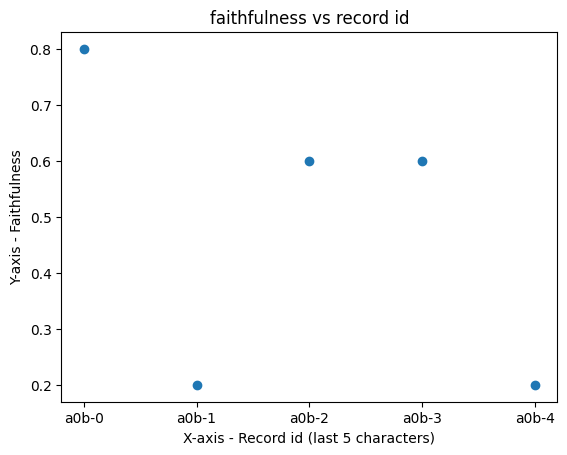

In [32]:
import matplotlib.pyplot as plt

plt.scatter(x, y_faithfulness, marker="o")

# Adding labels and title
plt.xlabel("X-axis - Record id (last 5 characters)")
plt.ylabel("Y-axis - Faithfulness")
plt.title("faithfulness vs record id")

# Display the graph
plt.show()

Plot answer relevance metrics against the records

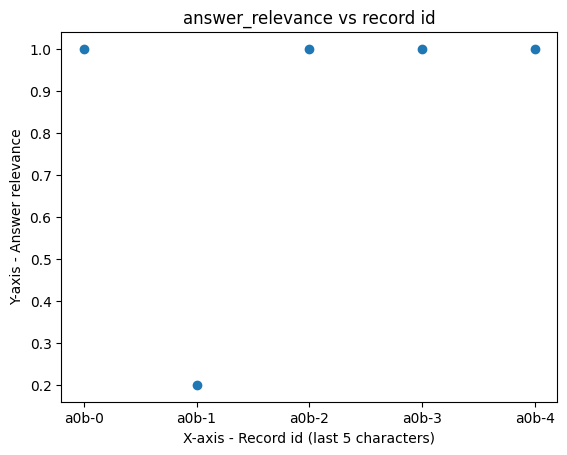

In [33]:
import matplotlib.pyplot as plt

plt.scatter(x, y_answer_relevance, marker="o")

# Adding labels and title
plt.xlabel("X-axis - Record id (last 5 characters)")
plt.ylabel("Y-axis - Answer relevance")
plt.title("answer_relevance vs record id")

# Display the graph
plt.show()

## Step 8 - See factsheets information <a name="factsheetsspace"></a>

In [34]:
factsheets_url = factsheets_url = (
    "{}/wx/prompt-details/{}/factsheet?context=wx&project_id={}".format(
        FACTSHEET_URL, project_pta_id, project_id
    )
)
print("User can navigate to the published facts in project {}".format(factsheets_url))

User can navigate to the published facts in project https://dataplatform.test.cloud.ibm.com/wx/prompt-details/67abfe24-5f2c-4a30-bd54-22867e199eb0/factsheet?context=wx&project_id=5295537f-5866-4432-92fc-4bcf65970e1f


## Evaluating a Prompt Template Asset from a space <a name="evaluatespace"></a>

So far, you have performed the following tasks:

1. Created a PTA in a project
2. Created a `development`-type subscription for a PTA in OpenScale
3. Configured monitors supported by OpenScale for the subscription
4. Performed risk evaluations against the PTA subscription with a sample set of test data
5. Displayed the metrics generated with the risk evaluation
6. Displayed the factsheets information for the subscription

Now, you will promote the created PTA to a space and perform similar actions.

## Step 9 - Promote a PTA to a space <a name="promottospace"></a> 

The following cell promotes the prompt template asset from your project to your space.

In [35]:
headers = {}
headers["Content-Type"] = "application/json"
headers["Accept"] = "*/*"
headers["Authorization"] = "Bearer {}".format(iam_access_token)
verify = True

verify = False
url = "{}/v2/assets/{}/promote".format(DATAPLATFORM_URL, project_pta_id)

params = {"project_id": project_id}

payload = {"space_id": space_id}
response = requests.post(
    url, json=payload, headers=headers, params=params, verify=verify
)
json_data = response.json()
json_data
space_pta_id = json_data["metadata"]["asset_id"]
space_pta_id

'395cc1f5-1f73-434e-97a0-f0a504d04075'

## Step 10 - Create a deployment for a PTA in a space <a name="ptadeployment"></a>

To create a subscription from a space, it is necessary to create a deployment for a PTA in a space.

In [36]:
DEPLOYMENTS_URL = CREDENTIALS["url"] + "/ml/v4/deployments"

serving_name = "rag_qa_deployments"  # eg: summary_deployment

payload = {
    "prompt_template": {"id": space_pta_id},
    "online": {"parameters": {"serving_name": serving_name}},
    "base_model_id": "google/flan-t5-xl",
    "description": "rag qa deployment",
    "name": "rag qa deployment",
    "space_id": space_id,
}

version = "2024-05-05"  # The version date for the API of the form YYYY-MM-DD. Example : 2023-07-07
params = {"version": version, "space_id": space_id}

response = requests.post(
    DEPLOYMENTS_URL, json=payload, headers=headers, params=params, verify=verify
)
json_data = response.json()


if "metadata" in json_data:
    deployment_id = json_data["metadata"]["id"]
    print(deployment_id)
else:
    print(json_data)

66a41504-c943-47cd-ae1e-30aeba5f7c7f


## Step 11 - Set up the PTA in a space for evaluation with supported monitor parameters <a name="ptaspace"></a>

Use of a PTA in a space is only supported with `pre_production` and `production` operational space IDs. Running the following cell will create a `production`-type subscription from the PTA promoted to the space. The `problem_type` value should depend on the task type specified in the PTA.

In [ ]:
label_column = "answer"
context_fields = ["context1", "context2", "context3"]
question_field = "question"

operational_space_id = "production"
problem_type = "retrieval_augmented_generation"
input_data_type = "unstructured_text"

monitors = {
    "generative_ai_quality": {
        "parameters": {
            "generative_ai_evaluator": { # global LLM as judge configuration
               "enabled": True,
               "evaluator_id": evaluator_id,
            },
            "min_sample_size": 5,
            "metrics_configuration": {
                "faithfulness": {
                    # "sample_size": 2, # Not supported for LLM as Judge
                    # "metric_prompt_template": "", # adding custom template
                    # Uncomment generative_ai_evaluator to use a different evaluator for this metric.
                    # Takes higher precedence than the generative_ai_evaluator specified at global level.
                    # "generative_ai_evaluator": {  # metric specific LLM as judge configuration
                    #     "enabled": True,
                    #     "evaluator_id": evaluator_id,
                    # },
                },
                "answer_relevance": {
                    # "sample_size": 2, # Not supported for LLM as Judge
                    # "metric_prompt_template": "", # adding custom template
                    # Uncomment generative_ai_evaluator to use a different evaluator for this metric
                    # Takes higher precedence than the generative_ai_evaluator specified at global level.
                    # "generative_ai_evaluator": {  # metric specific LLM as judge configuration
                    #     "enabled": True,
                    #     "evaluator_id": evaluator_id,
                    # },
                },
                "rouge_score": {},
                "exact_match": {},
                "bleu": {},
                "unsuccessful_requests": {
                    # "unsuccessful_phrases": []
                },
                "hap_input_score": {},
                "hap_score": {},
                "pii": {},
                "pii_input": {},
                "retrieval_quality": {
                    # "sample_size": 2, # Not supported for LLM as Judge
                    # Uncomment generative_ai_evaluator to use a different evaluator for this metric
                    # Takes higher precedence than the generative_ai_evaluator specified at global level.
                    # "generative_ai_evaluator": {  # metric specific LLM as judge configuration
                    #     "enabled": True,
                    #     "evaluator_id": evaluator_id,
                    # },
                    # The metrics computed for retrieval quality are context_relevance, retrieval_precision, average_precision, reciprocal_rank, hit_rate, normalized_discounted_cumulative_gain
                    # "context_relevance": {
                    #     "metric_prompt_template": "", # adding custom template
                    # }
                },
                # Answer similarity metric is supported only when LLM as judge is configured. Uncomment only when using LLM as judge.
                "answer_similarity": {
                    # "metric_prompt_template": "", # adding custom template
                    # Uncomment generative_ai_evaluator to use a different evaluator for this metric
                    # Takes higher precedence than the generative_ai_evaluator specified at global level.
                    # "generative_ai_evaluator": {  # metric specific LLM as judge configuration
                    #     "enabled": True,
                    #     "evaluator_id": evaluator_id,
                    # },
                },
            },
        }
    }
}

response = wos_client.wos.execute_prompt_setup(
    prompt_template_asset_id=space_pta_id,
    space_id=space_id,
    deployment_id=deployment_id,
    context_fields=context_fields,
    question_field=question_field,
    label_column=label_column,
    operational_space_id=operational_space_id,
    problem_type=problem_type,
    input_data_type=input_data_type,
    supporting_monitors=monitors,
    background_mode=False,
)

result = response.result
result._to_dict()




 Waiting for end of adding prompt setup 395cc1f5-1f73-434e-97a0-f0a504d04075 




running.
finished

---------------------------------------------------------------
 Successfully finished setting up prompt template subscription 
---------------------------------------------------------------




{'prompt_template_asset_id': '395cc1f5-1f73-434e-97a0-f0a504d04075',
 'space_id': '7d195a51-8938-4fc7-a2b6-cf8e254d67c5',
 'deployment_id': '66a41504-c943-47cd-ae1e-30aeba5f7c7f',
 'service_provider_id': '53a15d2d-9e10-4b80-b518-1d34d7315394',
 'subscription_id': 'd83a2091-d1c9-412a-8db1-5db2378fcc40',
 'mrm_monitor_instance_id': 'a5063da3-8766-4f63-9b30-031ffd47f512',
 'start_time': '2024-11-07T17:51:41.012579Z',
 'end_time': '2024-11-07T17:51:54.342244Z',
 'status': {'state': 'FINISHED'}}

With the following cell, you can read the prompt setup task and check its status:

In [38]:
response = wos_client.wos.get_prompt_setup(
    prompt_template_asset_id=space_pta_id,
    deployment_id=deployment_id,
    space_id=space_id,
)

result = response.result
result_json = result._to_dict()
result_json

{'prompt_template_asset_id': '395cc1f5-1f73-434e-97a0-f0a504d04075',
 'space_id': '7d195a51-8938-4fc7-a2b6-cf8e254d67c5',
 'deployment_id': '66a41504-c943-47cd-ae1e-30aeba5f7c7f',
 'service_provider_id': '53a15d2d-9e10-4b80-b518-1d34d7315394',
 'subscription_id': 'd83a2091-d1c9-412a-8db1-5db2378fcc40',
 'mrm_monitor_instance_id': 'a5063da3-8766-4f63-9b30-031ffd47f512',
 'start_time': '2024-11-07T17:51:41.012579Z',
 'end_time': '2024-11-07T17:51:54.342244Z',
 'status': {'state': 'FINISHED'}}

### Read the subscription ID from the prompt setup

Once the prompt setup status is `finished`, get the subscription ID:

In [39]:
prod_subscription_id = result_json["subscription_id"]
prod_subscription_id

'd83a2091-d1c9-412a-8db1-5db2378fcc40'

### Score the PTA deployment

Retrieve the scoring URL of the deployment from the subscription details.

In [40]:
sub_details = wos_client.subscriptions.get(prod_subscription_id).result
sub_details = sub_details._to_dict()
scoring_url = sub_details["entity"]["deployment"]["url"]
if not scoring_url.find("?version=") != -1:
    scoring_url = scoring_url.strip() + "?version=2024-05-05"

scoring_url = (
    CREDENTIALS["url"]
    + "/ml/v1/deployments/"
    + deployment_id
    + "/text/generation?version=2024-05-05"
)
print(scoring_url)

https://yp-qa.ml.cloud.ibm.com/ml/v1/deployments/66a41504-c943-47cd-ae1e-30aeba5f7c7f/text/generation?version=2024-05-05


## Step 12 - Score the model and configure monitors <a name="score"></a>

Once the WML service has been bound and the subscription has been created, you must score the PTA. Generate the test data content in JSON format from the previously-downloaded `.CSV` file. This is used to construct the payload for scoring the deployment.

In [41]:
test_data_path = "rag_state_union.csv"

In [42]:
import csv

feature_fields = context_fields + [question_field]
prediction = "generated_text"

headers = {}
headers["Content-Type"] = "application/json"
headers["Accept"] = "*/*"
headers["Authorization"] = "Bearer {}".format(iam_access_token)

pl_data = []
prediction_list = []
with open(test_data_path, "r") as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        request = {"parameters": {"template_variables": {}}}
        for each in feature_fields:
            request["parameters"]["template_variables"][each] = str(row[each])
        try:
            response = requests.post(
                scoring_url, json=request, headers=headers, verify=False
            ).json()
            predicted_val = response["results"][0][prediction]
            prediction_list.append(predicted_val)
            record = {"request": request, "response": response}
            pl_data.append(record)
        except:
            pass

pl_data

[{'request': {'parameters': {'template_variables': {'context1': 'Last month, I announced our plan to supercharge  the Cancer Moonshot that President Obama asked me to lead six years ago. Our goal is to cut the cancer death rate by at least 50% over the next 25 years, turn more cancers from death sentences into treatable diseases.  More support for patients and families. To get there, I call on Congress to fund ARPA-H, the Advanced Research Projects Agency for Health. It’s based on DARPA—the Defense Department project that led to the Internet, GPS, and so much more.  ARPA-H will have a singular purpose—to drive breakthroughs in cancer, Alzheimer’s, diabetes, and more. A unity agenda for the nation. We can do this. My fellow Americans—tonight , we have gathered in a sacred space—the citadel of our democracy. In this Capitol, generation after generation, Americans have debated great questions amid great strife, and have done great things. We have fought for freedom, expanded liberty, defe

### Add payload data

The following cell reads the payload data set ID from the subscription:

In [43]:
import time
from ibm_watson_openscale.supporting_classes.enums import *

time.sleep(5)
payload_data_set_id = None
payload_data_set_id = (
    wos_client.data_sets.list(
        type=DataSetTypes.PAYLOAD_LOGGING,
        target_target_id=prod_subscription_id,
        target_target_type=TargetTypes.SUBSCRIPTION,
    )
    .result.data_sets[0]
    .metadata.id
)
if payload_data_set_id is None:
    print("Payload data set not found. Please check subscription status.")
else:
    print("Payload data set id: ", payload_data_set_id)

Payload data set id:  0f7819b3-8bf1-42c7-9ab6-3ea5585e7d76


In [44]:
wos_client.data_sets.get_records_count(payload_data_set_id)

0

If auto payload logging fails to transmit the scored records to the payload logging table, the following code can be used to manually add payload data to the table:

In [45]:
time.sleep(5)
pl_records_count = wos_client.data_sets.get_records_count(payload_data_set_id)
print("Number of records in the payload logging table: {}".format(pl_records_count))
if pl_records_count < 6:
    print("Payload logging did not happen, performing explicit payload logging.")
    wos_client.data_sets.store_records(
        data_set_id=payload_data_set_id, request_body=pl_data, background_mode=False
    )
    time.sleep(5)
    pl_records_count = wos_client.data_sets.get_records_count(payload_data_set_id)
    print("Number of records in the payload logging table: {}".format(pl_records_count))

Number of records in the payload logging table: 0
Payload logging did not happen, performing explicit payload logging.



 Waiting for end of storing records with request id: 4a369dbd-2045-45ba-9779-db3ebaa2c21f 




active

---------------------------------------
 Successfully finished storing records 
---------------------------------------


Number of records in the payload logging table: 5


### Add feedback data

The following cell reads the feedback dataset ID from the subscription:

In [46]:
import time
from ibm_watson_openscale.supporting_classes.enums import *

time.sleep(5)
feedback_data_set_id = None
feedback_data_set_id = (
    wos_client.data_sets.list(
        type=DataSetTypes.FEEDBACK,
        target_target_id=prod_subscription_id,
        target_target_type=TargetTypes.SUBSCRIPTION,
    )
    .result.data_sets[0]
    .metadata.id
)
if feedback_data_set_id is None:
    print("Feedback data set not found. Please check subscription status.")
else:
    print("Feedback data set id: ", feedback_data_set_id)

Feedback data set id:  16da5e5b-9ef0-490d-b0de-38ea7e3395f4


The provided code generates feedback data based on the downloaded `.CSV` file and the scored response.

In [47]:
import csv

test_data_content = []
csv_file_path = "rag_state_union.csv"

with open(csv_file_path, "r") as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row, prediction_val in zip(csv_reader, prediction_list):

        # Read each row from the CSV and add label and prediction values
        result_row = []
        result_row = [row[key] for key in feature_fields if key in row]
        result_row.append(row[label_column])
        result_row.append(prediction_val)

        test_data_content.append(result_row)
if len(test_data_content) == 5:  # 5 records are there in the downloaded CSV
    print("generated feedback data from CSV")
else:
    print(
        "Failed to generated feedback data from CSV, Kindly verify the CSV file content"
    )

generated feedback data from CSV


In [48]:
fields = feature_fields
fields.append(label_column)
fields.append("_original_prediction")
feedback_data = [{"fields": fields, "values": test_data_content}]
feedback_data

[{'fields': ['context1',
   'context2',
   'context3',
   'question',
   'answer',
   '_original_prediction'],
  'values': [['Last month, I announced our plan to supercharge  the Cancer Moonshot that President Obama asked me to lead six years ago. Our goal is to cut the cancer death rate by at least 50% over the next 25 years, turn more cancers from death sentences into treatable diseases.  More support for patients and families. To get there, I call on Congress to fund ARPA-H, the Advanced Research Projects Agency for Health. It’s based on DARPA—the Defense Department project that led to the Internet, GPS, and so much more.  ARPA-H will have a singular purpose—to drive breakthroughs in cancer, Alzheimer’s, diabetes, and more. A unity agenda for the nation. We can do this. My fellow Americans—tonight , we have gathered in a sacred space—the citadel of our democracy. In this Capitol, generation after generation, Americans have debated great questions amid great strife, and have done gre

The following code can be used to manually add feedback data to the table.

In [49]:
wos_client.data_sets.store_records(
    data_set_id=feedback_data_set_id, request_body=feedback_data, background_mode=False
)
time.sleep(5)
fb_records_count = wos_client.data_sets.get_records_count(feedback_data_set_id)
time.sleep(10)
print("Number of records in the feedback logging table: {}".format(fb_records_count))




 Waiting for end of storing records with request id: 9ff0f418-114c-42e6-bf9c-b40fa0b5c623 




active

---------------------------------------
 Successfully finished storing records 
---------------------------------------


Number of records in the feedback logging table: 5


### Show all the monitor instances in the production subscription
The following cell lists the monitors present in the production subscription, along with their respective statuses and other details. Please wait for all the monitors to be in an active state before proceeding further:

In [50]:
wos_client.monitor_instances.show(target_target_id=prod_subscription_id)

dea2ecd3-2a6c-4fdd-8736-136b706d3707,active,d83a2091-d1c9-412a-8db1-5db2378fcc40,subscription,model_health,2024-11-07 17:51:46.465000+00:00,260a579f-e4dd-4f3b-8e35-ba038bc4e118
dea2ecd3-2a6c-4fdd-8736-136b706d3707,active,d83a2091-d1c9-412a-8db1-5db2378fcc40,subscription,generative_ai_quality,2024-11-07 17:51:45.805000+00:00,30d0208c-a006-4ce4-bdbf-262d5c90ba8a
dea2ecd3-2a6c-4fdd-8736-136b706d3707,active,d83a2091-d1c9-412a-8db1-5db2378fcc40,subscription,mrm,2024-11-07 17:51:47.097000+00:00,a5063da3-8766-4f63-9b30-031ffd47f512


### Read the Model Risk Metrics monitor instance ID of a PTA subscription deployed in a space

Evaluating the test data against the prompt template subscription requires the monitor instance ID of the Model Risk Metrics monitor.

In [51]:
monitor_definition_id = "mrm"
target_target_id = prod_subscription_id
result = wos_client.monitor_instances.list(
    data_mart_id=data_mart_id,
    monitor_definition_id=monitor_definition_id,
    target_target_id=target_target_id,
    space_id=space_id,
).result
result_json = result._to_dict()
mrm_monitor_id = result_json["monitor_instances"][0]["metadata"]["id"]
mrm_monitor_id

'a5063da3-8766-4f63-9b30-031ffd47f512'

### Evaluate the prompt template subscription from a space

The following cell will assess subscription of the prompt template asset and produce relevant measurements for the configured monitor. The data to be evaluated are already uploaded to payload and feedback table.

In [52]:
response = wos_client.monitor_instances.mrm.evaluate_risk(
    monitor_instance_id=mrm_monitor_id,
    body=body,
    space_id=space_id,
    background_mode=False,
)




 Waiting for risk evaluation of MRM monitor a5063da3-8766-4f63-9b30-031ffd47f512 




running...
finished

---------------------------------------
 Successfully finished evaluating risk 
---------------------------------------




### Read the risk evaluation response

After initiating the risk evaluation, the evaluation results of the PTA from your space are now available for review:

In [53]:
response = wos_client.monitor_instances.mrm.get_risk_evaluation(
    mrm_monitor_id, space_id=space_id
)
response.result.to_dict()

{'metadata': {'id': 'dae3a2ba-b8d7-4d66-b65f-881739e1997f',
  'created_at': '2024-11-07T17:57:36.833Z',
  'created_by': 'iam-ServiceId-b317a8da-d926-496e-b0ca-6bcc57f556ae'},
 'entity': {'triggered_by': 'user',
  'parameters': {'deployment_id': '66a41504-c943-47cd-ae1e-30aeba5f7c7f',
   'evaluation_start_time': '2024-11-07T17:57:34.911999Z',
   'facts': {'state': 'finished'},
   'measurement_id': 'f8e19268-38ff-45ee-ad83-0d8c46afb40d',
   'monitors_run_status': [{'monitor_id': 'generative_ai_quality',
     'status': {'state': 'finished'}},
    {'monitor_id': 'model_health', 'status': {'state': 'finished'}}],
   'prompt_template_asset_id': '395cc1f5-1f73-434e-97a0-f0a504d04075',
   'prompt_template_details': {'pta_resource_key': 'cde366a6306d17b32453422c270b01b9d50d2a1c2bc8e20224dc43a9a76414ca'},
   'space_id': '7d195a51-8938-4fc7-a2b6-cf8e254d67c5',
   'user_iam_id': 'IBMid-693000DYYL',
   'publish_metrics': 'false',
   'evaluation_tests': []},
  'status': {'state': 'finished',
   'que

### Display the Model Risk metrics

Having calculated the measurements for the Foundation Model subscription, the MModel Risk metrics generated for this subscription are now available for your review:

In [54]:
wos_client.monitor_instances.show_metrics(
    monitor_instance_id=mrm_monitor_id, space_id=space_id
)

2024-11-07 17:57:36.928000+00:00,tests_passed,f8e19268-38ff-45ee-ad83-0d8c46afb40d,0.0,None,None,[],mrm,a5063da3-8766-4f63-9b30-031ffd47f512,dae3a2ba-b8d7-4d66-b65f-881739e1997f,subscription,d83a2091-d1c9-412a-8db1-5db2378fcc40
2024-11-07 17:57:36.928000+00:00,tests_run,f8e19268-38ff-45ee-ad83-0d8c46afb40d,1.0,None,None,[],mrm,a5063da3-8766-4f63-9b30-031ffd47f512,dae3a2ba-b8d7-4d66-b65f-881739e1997f,subscription,d83a2091-d1c9-412a-8db1-5db2378fcc40
2024-11-07 17:57:36.928000+00:00,tests_skipped,f8e19268-38ff-45ee-ad83-0d8c46afb40d,3.0,None,None,[],mrm,a5063da3-8766-4f63-9b30-031ffd47f512,dae3a2ba-b8d7-4d66-b65f-881739e1997f,subscription,d83a2091-d1c9-412a-8db1-5db2378fcc40
2024-11-07 17:57:36.928000+00:00,tests_failed,f8e19268-38ff-45ee-ad83-0d8c46afb40d,1.0,None,None,[],mrm,a5063da3-8766-4f63-9b30-031ffd47f512,dae3a2ba-b8d7-4d66-b65f-881739e1997f,subscription,d83a2091-d1c9-412a-8db1-5db2378fcc40


### Display the Generative AI quality metrics

The monitor instance ID for the Generative AI quality metrics is required for reading its metrics:

In [55]:
monitor_definition_id = "generative_ai_quality"
result = wos_client.monitor_instances.list(
    data_mart_id=data_mart_id,
    monitor_definition_id=monitor_definition_id,
    target_target_id=target_target_id,
    space_id=space_id,
).result
result_json = result._to_dict()
genaiquality_monitor_id = result_json["monitor_instances"][0]["metadata"]["id"]
genaiquality_monitor_id

'30d0208c-a006-4ce4-bdbf-262d5c90ba8a'

Display the monitor metrics of the Generative AI quality metrics generated through the risk evaluation:

In [56]:
wos_client.monitor_instances.show_metrics(
    monitor_instance_id=genaiquality_monitor_id, space_id=space_id
)

2024-11-07 17:58:04.517325+00:00,hap_input_score,8490b5b3-c265-4104-9240-6ca4eef39e2e,0.0,None,0.0,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,30d0208c-a006-4ce4-bdbf-262d5c90ba8a,f60cfe80-1b0f-4c70-ab3e-bd825977a4ed,subscription,d83a2091-d1c9-412a-8db1-5db2378fcc40
2024-11-07 17:58:04.517325+00:00,rouge2,8490b5b3-c265-4104-9240-6ca4eef39e2e,0.096,0.8,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,30d0208c-a006-4ce4-bdbf-262d5c90ba8a,f60cfe80-1b0f-4c70-ab3e-bd825977a4ed,subscription,d83a2091-d1c9-412a-8db1-5db2378fcc40
2024-11-07 17:58:04.517325+00:00,faithfulness,8490b5b3-c265-4104-9240-6ca4eef39e2e,0.48,0.7,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,30d0208c-a006-4ce4-bdbf-262d5c90ba8a,f60cfe80-1b0f-4c70-ab3e-bd825977a4ed,subscription,d83a2091-d1c9-412a-8db1-5db2378fcc40
2024-11-07 17:58:04.517325+00:00,average_precision,8490b5b3-c265-4104-9240-6ca4eef39e2e,0.86,0.7,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,30d0208c-a006-4ce4-bdbf-262d5c90ba8a,f60cfe80-1b0f-4c70-ab3e-bd825977a4ed,subscription,d83a2091-d1c9-412a-8db1-5db2378fcc40
2024-11-07 17:58:04.517325+00:00,records_processed,8490b5b3-c265-4104-9240-6ca4eef39e2e,5.0,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,30d0208c-a006-4ce4-bdbf-262d5c90ba8a,f60cfe80-1b0f-4c70-ab3e-bd825977a4ed,subscription,d83a2091-d1c9-412a-8db1-5db2378fcc40
2024-11-07 17:58:04.517325+00:00,hit_rate,8490b5b3-c265-4104-9240-6ca4eef39e2e,1.0,0.7,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,30d0208c-a006-4ce4-bdbf-262d5c90ba8a,f60cfe80-1b0f-4c70-ab3e-bd825977a4ed,subscription,d83a2091-d1c9-412a-8db1-5db2378fcc40
2024-11-07 17:58:04.517325+00:00,rougelsum,8490b5b3-c265-4104-9240-6ca4eef39e2e,0.1765,0.8,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,30d0208c-a006-4ce4-bdbf-262d5c90ba8a,f60cfe80-1b0f-4c70-ab3e-bd825977a4ed,subscription,d83a2091-d1c9-412a-8db1-5db2378fcc40
2024-11-07 17:58:04.517325+00:00,answer_relevance,8490b5b3-c265-4104-9240-6ca4eef39e2e,0.84,0.7,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,30d0208c-a006-4ce4-bdbf-262d5c90ba8a,f60cfe80-1b0f-4c70-ab3e-bd825977a4ed,subscription,d83a2091-d1c9-412a-8db1-5db2378fcc40
2024-11-07 17:58:04.517325+00:00,hap_score,8490b5b3-c265-4104-9240-6ca4eef39e2e,0.0,None,0.0,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,30d0208c-a006-4ce4-bdbf-262d5c90ba8a,f60cfe80-1b0f-4c70-ab3e-bd825977a4ed,subscription,d83a2091-d1c9-412a-8db1-5db2378fcc40
2024-11-07 17:58:04.517325+00:00,reciprocal_rank,8490b5b3-c265-4104-9240-6ca4eef39e2e,0.8667,0.7,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,30d0208c-a006-4ce4-bdbf-262d5c90ba8a,f60cfe80-1b0f-4c70-ab3e-bd825977a4ed,subscription,d83a2091-d1c9-412a-8db1-5db2378fcc40


Note: First 10 records were displayed.


## Step 13 - Display the source attribution for a record

Read the dataset ID for the Generative AI quality dataset:

In [57]:
result = wos_client.data_sets.list(
    target_target_id=prod_subscription_id,
    target_target_type="subscription",
    type="gen_ai_quality_metrics",
).result

genaiq_dataset_id = result.data_sets[0].metadata.id
genaiq_dataset_id

'a65e37e1-cb3a-4288-924b-b83bf7067873'

Display record level metrics for Generative AI quality:

In [58]:
wos_client.data_sets.show_records(data_set_id=genaiq_dataset_id)

0.0009044734761118889,0.0,0.2,[],0.3,386937f1-08a6-4eed-804f-50bdbb07218e,1.0,feedback,2024-11-07T17:56:53.668Z,0.0714,1.0,"{'faithfulness': 0.2, 'faithfulness_attributions': []}","{'context_columns': ['context1', 'context2', 'context3'], 'context_relevances': [0.2, 0.2, 0.8]}",0.0012875042157247663,0.3333333333333333,[],0.7459,0.0,None,0.3333,None,0.0,f60cfe80-1b0f-4c70-ab3e-bd825977a4ed,0.8,None,None,0.0714,1.0,0.0,0.0,None,0.0,None,0.0714
0.005944382399320602,0.2041,0.8,[],1.0,3c39727a-38f8-41ff-8953-250e2d5f76a6,1.0,feedback,2024-11-07T17:56:53.668Z,0.2353,1.0,"{'faithfulness': 0.8, 'faithfulness_attributions': []}","{'context_columns': ['context1', 'context2', 'context3'], 'context_relevances': [0.8, 0.2, 0.2]}",0.0004201263946015388,1.0,[],1.0,0.0,None,0.3333,None,0.00010446414383170532,f60cfe80-1b0f-4c70-ab3e-bd825977a4ed,0.8,None,None,0.2353,1.0,0.0,0.0,None,0.0,None,0.2353
0.0008792144944891334,0.0,0.6,[],1.0,3d824b43-ccb9-4ac5-ba8f-4cc2f117c255,1.0,feedback,2024-11-07T17:56:53.668Z,0.1818,1.0,"{'faithfulness': 0.6, 'faithfulness_attributions': []}","{'context_columns': ['context1', 'context2', 'context3'], 'context_relevances': [1.0, 0.8, 0.4]}",0.0010992378229275346,1.0,[],1.0,0.0,None,0.6667,None,0.0,f60cfe80-1b0f-4c70-ab3e-bd825977a4ed,1.0,None,None,0.1818,1.0,0.0,0.0,None,0.0,None,0.1818
0.0009061573073267937,0.0408,0.2,[],1.0,6d5b8795-a155-459c-a0bc-ceb53eca129b,1.0,feedback,2024-11-07T17:56:53.668Z,0.0784,0.2,"{'faithfulness': 0.2, 'faithfulness_attributions': []}","{'context_columns': ['context1', 'context2', 'context3'], 'context_relevances': [0.8, 0.2, 0.2]}",0.0010436080629006028,1.0,[],1.0,0.0,None,0.3333,None,0.0,f60cfe80-1b0f-4c70-ab3e-bd825977a4ed,0.8,None,None,0.0784,1.0,0.0,0.0,None,0.0,None,0.0784
0.0013096387265250087,0.2353,0.6,[],1.0,a840ef0a-ea86-471b-a4e3-be14f1be376e,1.0,feedback,2024-11-07T17:56:53.668Z,0.3158,1.0,"{'faithfulness': 0.6, 'faithfulness_attributions': []}","{'context_columns': ['context1', 'context2', 'context3'], 'context_relevances': [0.8, 0.4, 0.2]}",0.009054477326571941,1.0,[],1.0,0.0,None,0.3333,None,0.0,f60cfe80-1b0f-4c70-ab3e-bd825977a4ed,0.8,None,None,0.3158,1.0,0.0,0.0,None,0.0,None,0.3158
0.0009044734761118889,nan,0.2,[],0.3,48b7549b-5e41-4542-a46f-02edda4b2eef-1,1.0,payload_logging,2024-11-07T17:55:21.263Z,nan,1.0,"{'faithfulness': 0.2, 'faithfulness_attributions': []}","{'context_columns': ['context1', 'context2', 'context3'], 'context_relevances': [0.2, 0.2, 0.8]}",0.0012875042157247663,0.3333333333333333,[],0.7459,0.0,None,0.3333,None,nan,f60cfe80-1b0f-4c70-ab3e-bd825977a4ed,0.8,None,None,nan,nan,nan,0.0,None,0.0,None,nan
0.0013096387265250087,nan,0.6,[],1.0,0ebd004d-80be-4e96-81b6-ba8a338f1250-1,1.0,payload_logging,2024-11-07T17:55:21.262Z,nan,1.0,"{'faithfulness': 0.6, 'faithfulness_attributions': []}","{'context_columns': ['context1', 'context2', 'context3'], 'context_relevances': [0.8, 0.4, 0.2]}",0.009054477326571941,1.0,[],1.0,0.0,None,0.3333,None,nan,f60cfe80-1b0f-4c70-ab3e-bd825977a4ed,0.8,None,None,nan,nan,nan,0.0,None,0.0,None,nan
0.0008792144944891334,nan,0.6,[],1.0,f4c11aec-f412-4397-8305-b4681a4aae15-1,1.0,payload_logging,2024-11-07T17:55:21.261Z,nan,1.0,"{'faithfulness': 0.6, 'faithfulness_attributions': []}","{'context_columns': ['context1', 'context2', 'context3'], 'context_relevances': [1.0, 0.8, 0.4]}",0.0010992378229275346,1.0,[],1.0,0.0,None,0.6667,None,nan,f60cfe80-1b0f-4c70-ab3e-bd825977a4ed,1.0,None,None,nan,nan,nan,0.0,None,0.0,None,nan
0.0009061573073267937,nan,0.2,[],1.0,224edcc6-8105-4ce5-b64c-4cccd329d94a-1,1.0,payload_logging,2024-11-07T17:55:21.260Z,nan,0.2,"{'faithfulness': 0.2, 'faithfulness_attributions': []}","{'context_columns': ['context1', 'context2', 'context3'], 'context_relevances': [0.8, 0.2, 0.2]}",0.0010436080629006028,1.0,[],1.0,0.0,None,0.3333,None,nan,f60cfe80-1b0f-4c70-ab3e-bd825977a4ed,0.8,None,None,nan,nan,nan,0.0,None,0.0,None,nan
0.005944382399320602,nan,0.8,[],1.0,650e46b5-cee4-476d-9260-c03b0abcbc0c-1,1.0,payload_

### Display source attributions for a record from payload or feedback data <a name="attributions"></a>

Get a record from payload table. The below method can also be used to get the record from feedback table by providing the feedback dataset id

In [59]:
result = wos_client.data_sets.get_list_of_records(
    data_set_id=payload_data_set_id, limit=1
).result
record = result["records"][0]["entity"]["values"]
scoring_id = record.get("scoring_id")
scoring_id

'48b7549b-5e41-4542-a46f-02edda4b2eef-1'

Get the source attributions from generative ai quality dataset for the scoring id

In [60]:
import pandas as pd

metrics_result = wos_client.data_sets.get_list_of_records(
    data_set_id=genaiq_dataset_id, filter="scoring_id:eq:{}".format(scoring_id)
).result
record_metrics = metrics_result["records"][0]["entity"]["values"]
attributions, attribution_scores = [], []
for i in record_metrics.get("faithfulness_attributions")["faithfulness_attributions"]:
    for attr in i["attributions"]:
        attributions.extend(attr.get("feature_values"))
        attribution_scores.extend(attr.get("faithfulness_scores"))

attributions_df = pd.DataFrame(
    {"faithfulness attribution": attributions, "attribution score": attribution_scores}
)
pd.set_option("display.max_colwidth", 0)
attributions_df.sort_values(by=["attribution score"], inplace=True, ascending=False)
print("Question: {}".format(record.get("question")))
print("Answer: {}".format(record.get("generated_text")))
print("Attributions: ")
attributions_df

Question: How many electric vehicle charging stations are built?
Answer: 500,000
Attributions: 


,faithfulness attribution,attribution score


## Step 14 - Plot faithfulness and answer relevance metrics against records <a name="plotspace"></a>

Retrieve a list of records and extract the record IDs, faithfulness values, and answer relevance values:

In [61]:
result = wos_client.data_sets.get_list_of_records(data_set_id=genaiq_dataset_id).result
result["records"]
x = []
y_faithfulness = []
y_answer_relevance = []
for each in result["records"]:
    x.append(
        each["metadata"]["id"][-5:]
    )  # Reading only last 5 characters to fit in the display
    y_faithfulness.append(each["entity"]["values"]["faithfulness"])
    y_answer_relevance.append(each["entity"]["values"]["answer_relevance"])

Plot faithfulness metrics against the records

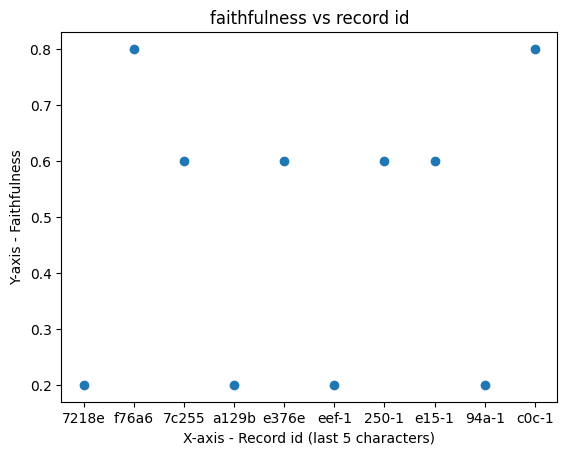

In [62]:
import matplotlib.pyplot as plt

plt.scatter(x, y_faithfulness, marker="o")

# Adding labels and title
plt.xlabel("X-axis - Record id (last 5 characters)")
plt.ylabel("Y-axis - Faithfulness")
plt.title("faithfulness vs record id")

# Display the graph
plt.show()

Plot answer_relevance metrics against the records

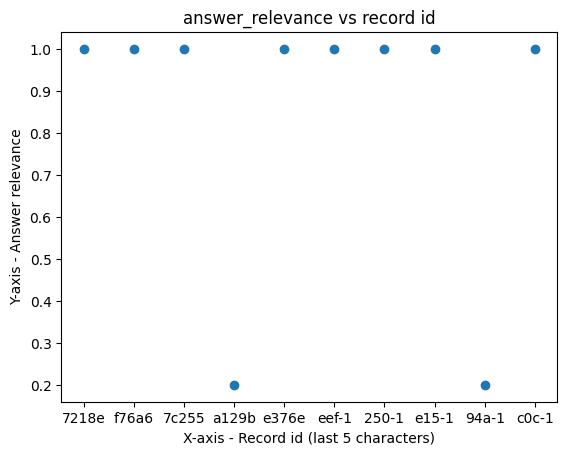

In [63]:
import matplotlib.pyplot as plt

plt.scatter(x, y_answer_relevance, marker="o")

# Adding labels and title
plt.xlabel("X-axis - Record id (last 5 characters)")
plt.ylabel("Y-axis - Answer relevance")
plt.title("answer_relevance vs record id")

# Display the graph
plt.show()

## Step 15 - See factsheets information from a space <a name="factsheetsproject"></a>

In [64]:
factsheets_url = (
    "{}/ml-runtime/deployments/{}/details?space_id={}&context=wx&flush=true".format(
        FACTSHEET_URL, deployment_id, space_id
    )
)

print("User can navigate to the published facts in space {}".format(factsheets_url))

User can navigate to the published facts in space https://dataplatform.test.cloud.ibm.com/ml-runtime/deployments/66a41504-c943-47cd-ae1e-30aeba5f7c7f/details?space_id=7d195a51-8938-4fc7-a2b6-cf8e254d67c5&context=wx&flush=true


## Congratulations!

You have completed this notebook. You can now navigate to the prompt template asset in your OpenScale project / space and click on the `Evaluate` tab to visualize the results in the UI.

watsonx.governance

Copyright © 2024 IBM.